In [1]:
import re

import pandas as pd
from pathlib import Path
from ploting import *

In [2]:
name_re = re.compile("(weak|strong)_scaling-d_(\d+)-n_(\d+)-([\w_]+)_comm-(gpu|cpu)-nodes_(\d+)")

In [3]:
time_re = re.compile("DURATION:\s*(\d+(\.\d+)?(e[+-]\d+)?)")

In [4]:
def create_df(path):
    data = []
    for file in Path(f"{path}/data").iterdir():
        if m := name_re.search(file.name):
            with open(file, "r") as input:
                if t_m := time_re.search(input.read()):
                    duration = t_m.group(1)
                    data.append({"scaling": m.group(1), "dim": m.group(2), "n": m.group(3), "comm_pattern": m.group(4),
                                 "type": m.group(5), "nodes": m.group(6), "time": duration})
    df = pd.DataFrame(data)
    df = df[df.comm_pattern == "stencil"]
    return df.drop(columns=["scaling", "type", "comm_pattern"]).astype({"dim": int, "n": int, "nodes": int, "time": float})

In [5]:
def pivot(df):
    piv = df.pivot(index="nodes", columns=["dim", "n"], values="time")
    return piv[piv.columns.sort_values()]

In [6]:
df_gpu_aware = create_df("horeka")
df_gpu_aware = pivot(df_gpu_aware)
df_gpu_aware

dim           3                                        
n       100       1000      10000     100000    1000000
nodes                                                  
1      0.113649  0.122895  0.152077  0.237025  0.645848
2      0.135105  0.146622  0.173959  0.439350  1.373790
4      0.146671  0.158665  0.880006  0.462210  1.411450
7      0.152868  0.165745  0.204780  0.473269  1.418380
14     0.168402  0.182534  0.208753  0.696000  2.666700
28     0.236412  0.194973  0.850220  0.591123  3.768770
56     0.243728  0.224780  0.908624  0.648293  2.154290

In [7]:
df_gpu_unaware = create_df("horeka-no-gpu-aware-mpi")
df_gpu_unaware = pivot(df_gpu_unaware)
df_gpu_unaware

dim           3                                       
n       100       1000      10000     100000   1000000
nodes                                                 
1      0.217885  0.223601  0.238432  0.330533  1.02927
2      0.230136  0.235043  0.256149  0.389387  1.18321
4      0.236875  0.243379  0.263313  0.404223  1.20454
7      0.245222  0.251083  0.273109  0.413838  1.22144
14     0.272332  0.274380  0.295900  0.441482  1.86673
28     0.298205  0.299598  0.328916  0.482554  2.62198
56     0.358276  0.347082  0.385236  0.559371  1.63961

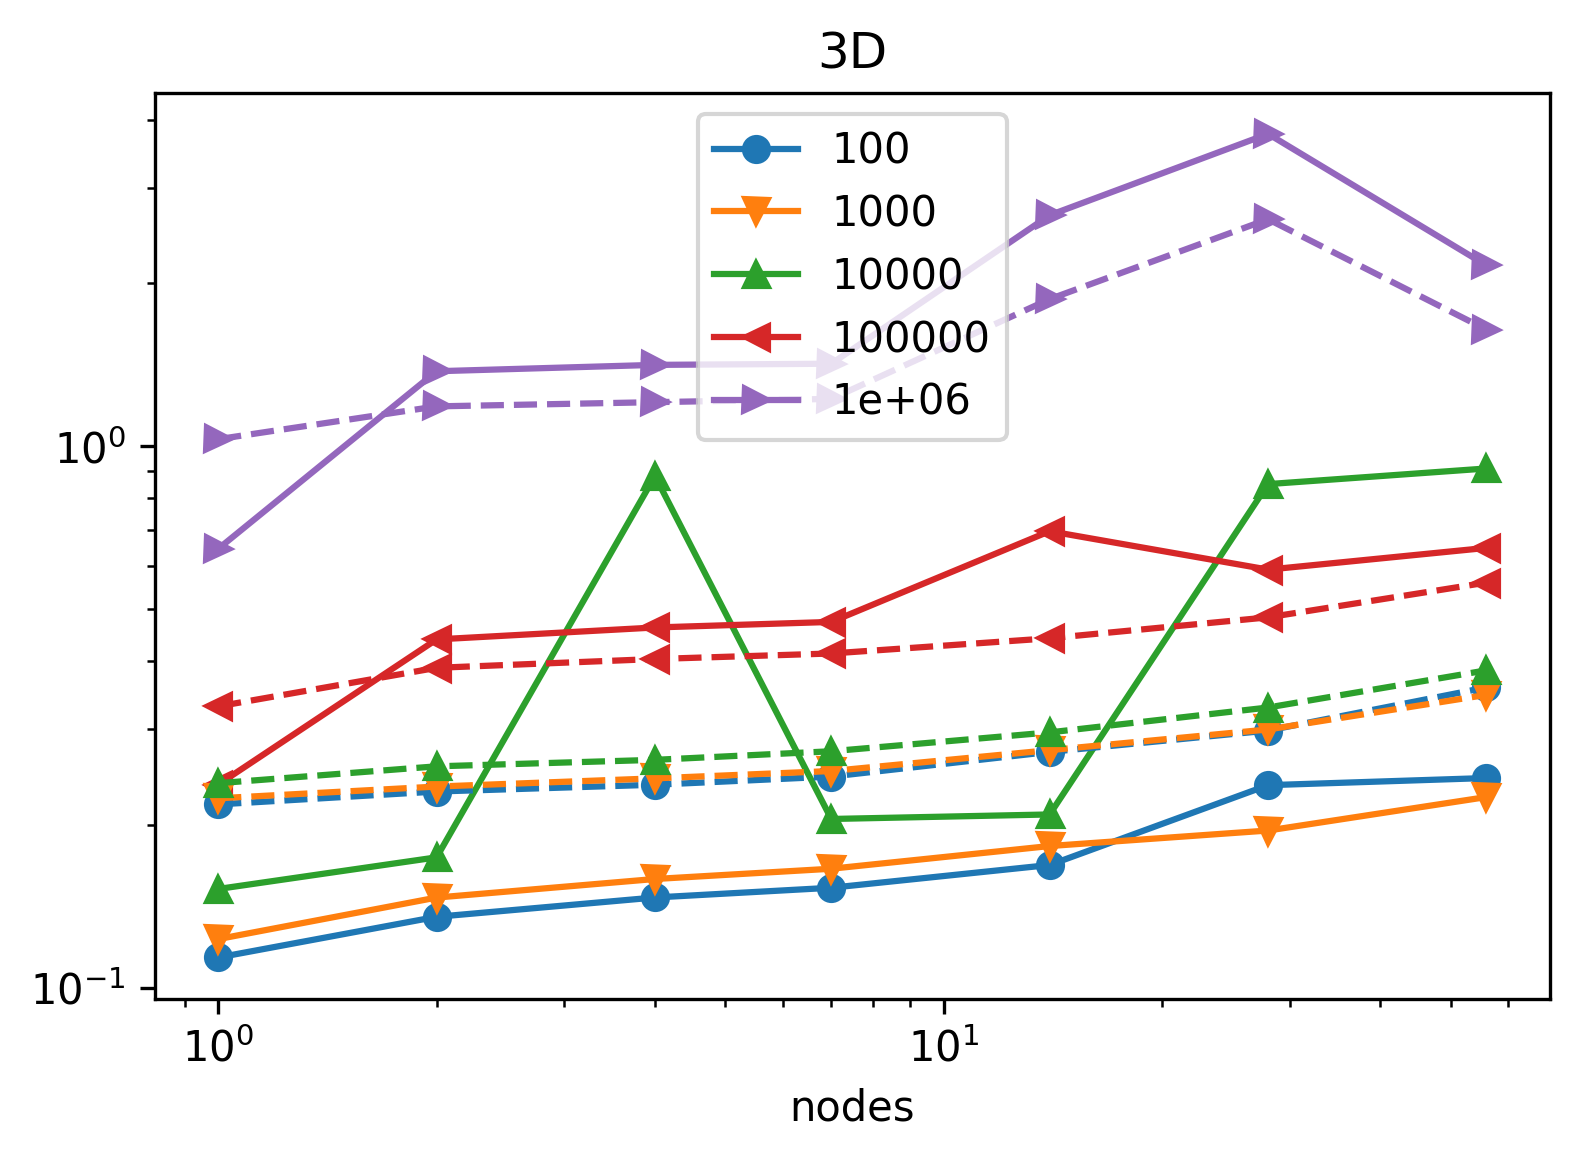

In [8]:
for dim in df_gpu_unaware.columns.levels[0]:
    fig, ax = plt.subplots(dpi=300)
    for piv, is_gpu_aware in [(df_gpu_aware, True), (df_gpu_unaware, False)]:
        _df = piv[dim]
        ax.set_prop_cycle(default_cycler if is_gpu_aware else dashed_cylcer)
        ax.set_title(f"{dim}D")
        _df.plot(ax=ax, legend=False, logx=True, logy=True)
        if is_gpu_aware:
            ax.legend([f"{n:g}" for n in piv.columns.levels[1]])
    #fig.savefig(f"runtime-mpi-comparison-{dim}d.png")